# Transformation of vdatum with pyproj for Australia (AHD)

Compute and plot height difference between Australian Height Datum and WGS84

In [1]:
import numpy as np
import pyproj
import xarray as xr

pyproj.network.set_network_enabled(active=True)

# crs
wgs84 = 4979  # WGS 84
wgs84_egm2008 = 9518  # WGS84 + EGM2008 height
wgs84_msl = 9705  # WGS 84 + MSL height
gda2020_ahd = 9463  # GDA2020 + AHD

# resolution
n = 200

bounds = pyproj.CRS.from_epsg(gda2020_ahd).area_of_use.bounds
lon = np.linspace(*bounds[0::2], n)
lat = np.linspace(*bounds[1::2], n // 2)

longitude, latitude = np.meshgrid(lon, lat)

# create dummy grid
ds = xr.Dataset(
    coords=dict(
        lon=lon,
        lat=lat,
        longitude=(("lat", "lon"), longitude),
        latitude=(("lat", "lon"), latitude),
    )
)  # .chunk(lon=20, lat=20)


def _offset(lat, lon, height, transformer):
    """helper function"""
    return transformer.transform(lon, lat, height)


def offset(lon, lat, height, transformer):
    """apply helper function on xarray coordinates"""
    return xr.apply_ufunc(
        _offset,
        lon,
        lat,
        height,
        input_core_dims=[lon.dims, lat.dims, height.dims],
        output_core_dims=[lon.dims, lat.dims, height.dims],
        kwargs={"transformer": transformer},
        # dask="parallelized",
        # dask_gufunc_kwargs={"allow_rechunk":True}
    )

## Reference to EGM2008 (Mean sea level)

This reference should be more of less mean sea level.

In [2]:
trg = pyproj.CRS("EPSG:4326+3855")  # EGM2008
src = pyproj.CRS("EPSG:4326+5711")  # AHD

# transformer
transformer = pyproj.Transformer.from_crs(
    crs_from=src.to_3d(), crs_to=trg.to_3d(), always_xy=True
)

# Use zeros as reference height:
%time x, y, z = offset(ds.latitude, ds.longitude, xr.zeros_like(ds.longitude), transformer)

CPU times: user 9.4 s, sys: 734 ms, total: 10.1 s
Wall time: 10.7 s


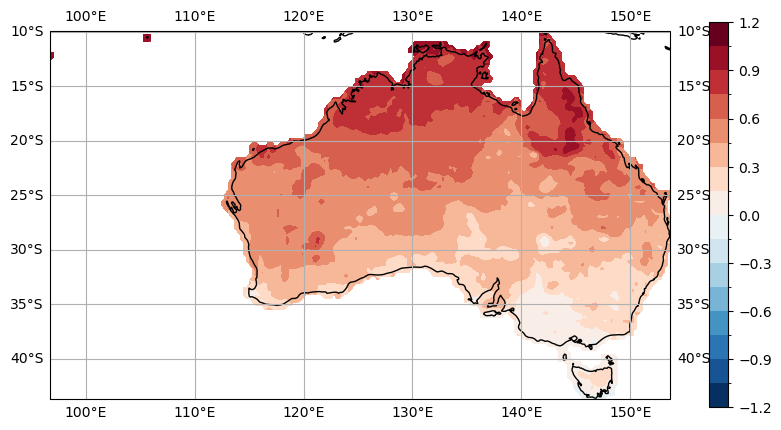

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

z.plot.contourf(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(), levels=20)

## Reference to EMG96 (Mean sea level)

In [4]:
trg = pyproj.CRS("EPSG:4326+5773")  # EGM96
src = pyproj.CRS("EPSG:4326+5711")  # AHD

# transformer
transformer = pyproj.Transformer.from_crs(
    crs_from=src.to_3d(), crs_to=trg.to_3d(), always_xy=True
)

# Use zeros as reference height:
%time x, y, z = offset(ds.latitude, ds.longitude, xr.zeros_like(ds.longitude), transformer)

CPU times: user 9.5 s, sys: 670 ms, total: 10.2 s
Wall time: 10.7 s


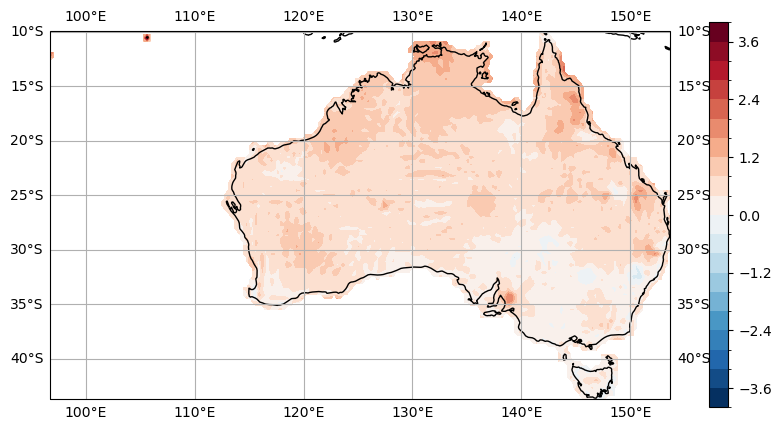

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

z.plot.contourf(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(), levels=20)

## Reference WGS84 (Reference Ellipsoid)

Reference Ellipsoid

In [6]:
trg = pyproj.CRS("EPSG:4979")
src = pyproj.CRS("EPSG:4326+5711")  # AHD

# transformer
transformer = pyproj.Transformer.from_crs(
    crs_from=src.to_3d(), crs_to=trg.to_3d(), always_xy=True
)

# Use zeros as reference height:
%time x, y, z = offset(ds.latitude, ds.longitude, xr.zeros_like(ds.longitude), transformer)

CPU times: user 3.94 s, sys: 639 ms, total: 4.58 s
Wall time: 5.06 s


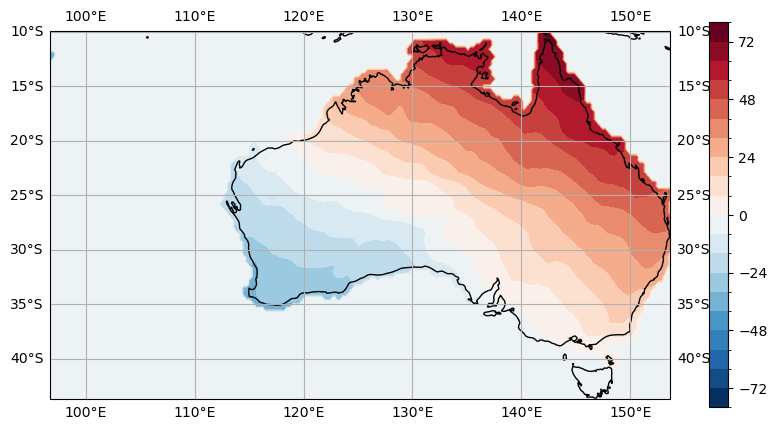

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

z.plot.contourf(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(), levels=20)